In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, auc
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import sklearn.metrics as mt
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

df1 = pd.read_csv('/content/Womens Clothing E-Commerce Reviews.csv')
df = df1[['Review Text','Rating','Class Name','Age']]
df1.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [ ]:
# fill NA values by space
df['Review Text'] = df['Review Text'].fillna('')

# CountVectorizer() converts a collection
# of text documents to a matrix of token counts
vectorizer = CountVectorizer()
# assign a shorter name for the analyze
# which tokenizes the string
analyzer = vectorizer.build_analyzer()

def wordcounts(s):
    c = {}
    # tokenize the string and continue, if it is not empty
    if analyzer(s):
        d = {}
        # find counts of the vocabularies and transform to array
        w = vectorizer.fit_transform([s]).toarray()
        # vocabulary and index (index of w)
        vc = vectorizer.vocabulary_
        # items() transforms the dictionary's (word, index) tuple pairs
        for k,v in vc.items():
            d[v]=k # d -> index:word
        for index,i in enumerate(w[0]):
            c[d[index]] = i # c -> word:count
    return  c

# add new column to the dataframe
df['Word Counts'] = df['Review Text'].apply(wordcounts)
df.head()

,Review Text,Rating,Class Name,Age,Word Counts
0,Absolutely wonderful - silky and sexy and comf...,4,Intimates,33,"{'absolutely': 1, 'and': 2, 'comfortable': 1, ..."
1,Love this dress! it's sooo pretty. i happene...,5,Dresses,34,"{'am': 1, 'and': 2, 'bc': 2, 'be': 1, 'below':..."
2,I had such high hopes for this dress and reall...,3,Dresses,60,"{'and': 3, 'be': 1, 'bottom': 1, 'but': 2, 'ch..."
3,"I love, love, love this jumpsuit. it's fun, fl...",5,Pants,50,"{'and': 1, 'but': 1, 'compliments': 1, 'every'..."
4,This shirt is very flattering to all due to th...,5,Blouses,47,"{'adjustable': 1, 'all': 1, 'and': 1, 'any': 1..."


Selected Words
love     8951
great    6117
super    1726
happy     705
glad      614
dtype: int64

Class Names
Dresses     6319
Knits       4843
Blouses     3097
Sweaters    1428
Pants       1388
Name: Class Name, dtype: int64


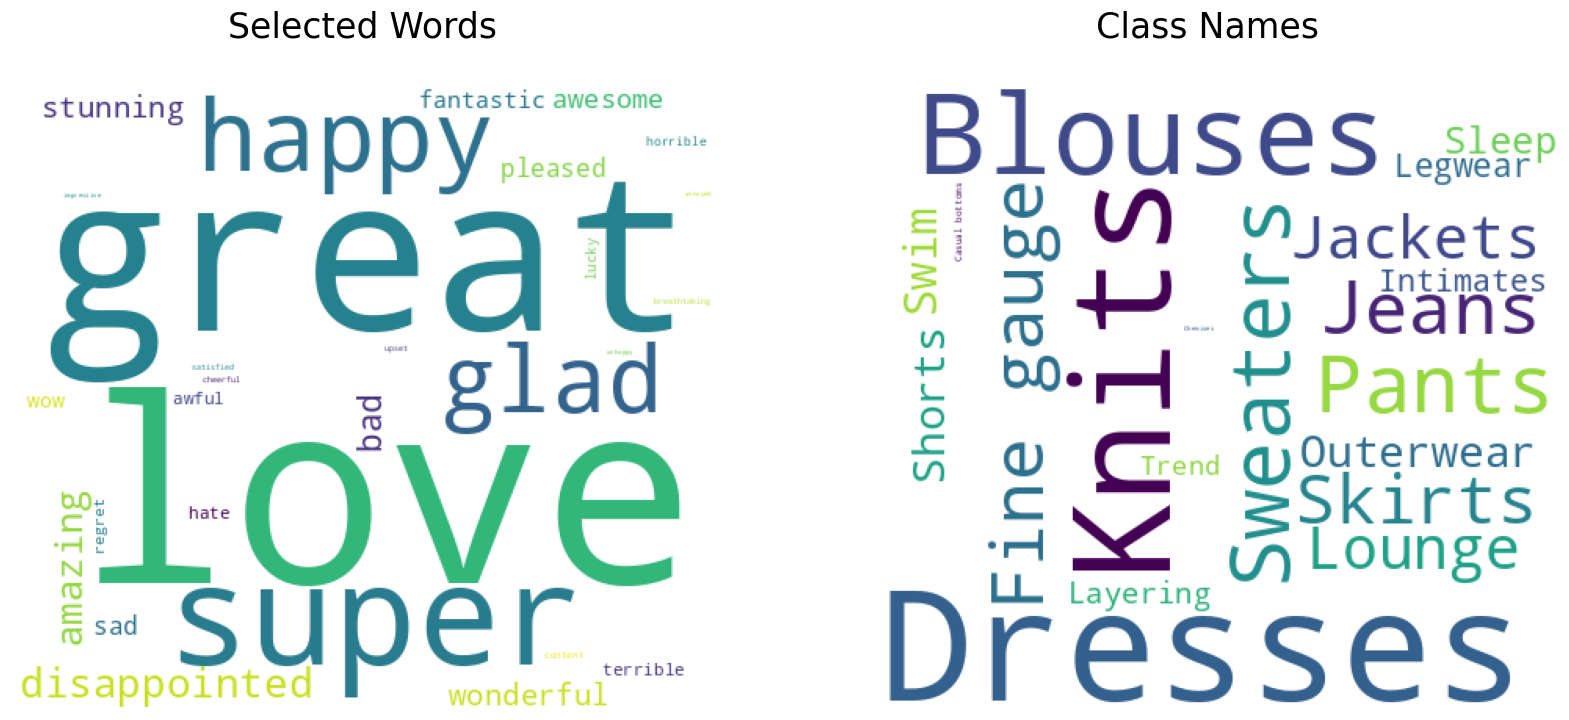

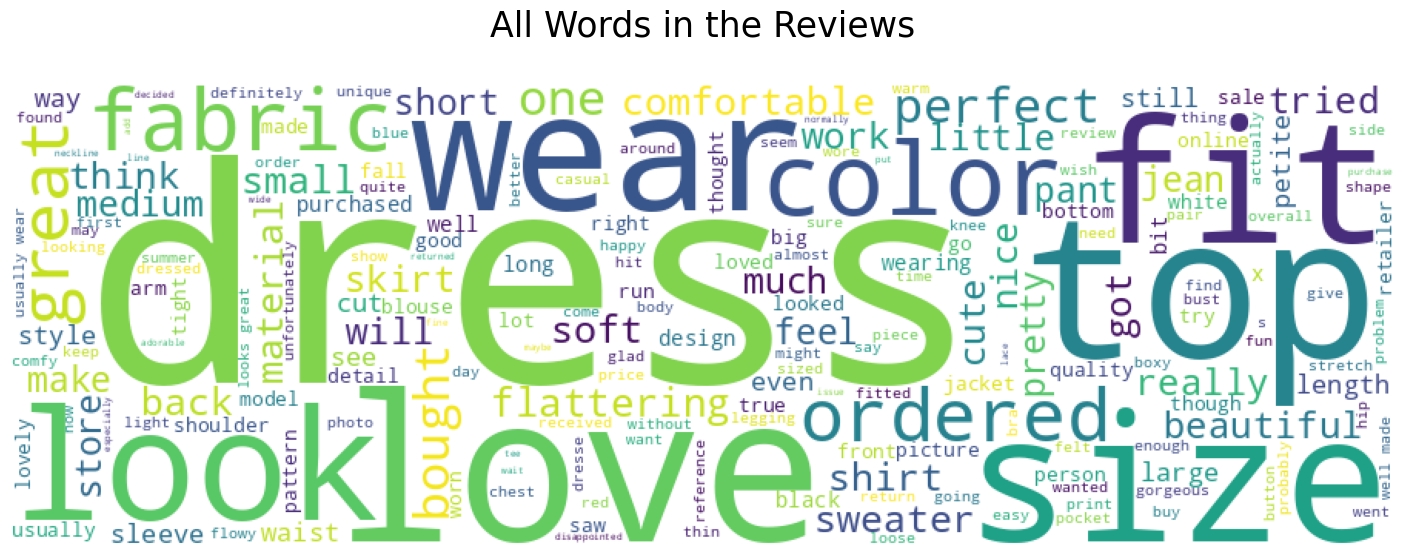

In [ ]:
# selecting some words to examine detailed
selectedwords = ['awesome','great','fantastic','extraordinary','amazing','super',
                 'magnificent','stunning','impressive','wonderful','breathtaking',
                 'love','content','pleased','happy','glad','satisfied','lucky',
                 'shocking','cheerful','wow','sad','unhappy','horrible','regret',
                 'bad','terrible','annoyed','disappointed','upset','awful','hate']

def selectedcount(dic,word):
    if word in dic:
        return dic[word]
    else:
        return 0

dfwc = df.copy()
for word in selectedwords:
    dfwc[word] = dfwc['Word Counts'].apply(selectedcount,args=(word,))

word_sum = dfwc[selectedwords].sum()
print('Selected Words')
print(word_sum.sort_values(ascending=False).iloc[:5])

print('\nClass Names')
print(df['Class Name'].fillna("Empty").value_counts().iloc[:5])

fig, ax = plt.subplots(1,2,figsize=(20,10))
wc0 = WordCloud(background_color='white',
                      width=450,
                      height=400 ).generate_from_frequencies(word_sum)

cn = df['Class Name'].fillna(" ").value_counts()
wc1 = WordCloud(background_color='white',
                      width=450,
                      height=400
                     ).generate_from_frequencies(cn)

ax[0].imshow(wc0)
ax[0].set_title('Selected Words\n',size=25)
ax[0].axis('off')

ax[1].imshow(wc1)
ax[1].set_title('Class Names\n',size=25)
ax[1].axis('off')

rt = df['Review Text']
plt.subplots(figsize=(18,6))
wordcloud = WordCloud(background_color='white',
                      width=900,
                      height=300
                     ).generate(" ".join(rt))
plt.imshow(wordcloud)
plt.title('All Words in the Reviews\n',size=25)
plt.axis('off')
plt.show()

In [ ]:
# Rating of 4 or higher -> positive, while the ones with
# Rating of 2 or lower -> negative
# Rating of 3 -> neutral
df = df[df['Rating'] != 3]
df['Sentiment'] = df['Rating'] >=4
df.head()

# split data
train_data,test_data = train_test_split(df,train_size=0.8,random_state=0)
# select the columns and
# prepare data for the models
X_train = vectorizer.fit_transform(train_data['Review Text'])
y_train = train_data['Sentiment']
X_test = vectorizer.transform(test_data['Review Text'])
y_test = test_data['Sentiment']

In [ ]:
start=dt.datetime.now()
svm = SVC()
svm.fit(X_train,y_train)
print('Elapsed time: ',str(dt.datetime.now()-start))

Elapsed time:  0:00:50.181707


In [ ]:
# define a dataframe for the prediction probablities of the models
#df1 = train_data.copy()
#df1['SVM'] = svm.decision_function(X_train)
#df1=df1.round(2)
#df1.head()

# define a dataframe for the predictions
df2 = train_data.copy()
df2['SVM'] = svm.predict(X_train)

df2.head()

,Review Text,Rating,Class Name,Age,Word Counts,Sentiment,SVM
19218,I love this dress's gentle blue lace. the silh...,5,Dresses,35,"{'and': 1, 'as': 1, 'blue': 1, 'chest': 1, 'dr...",True,True
3530,Beautiful choice...beautiful fit for my daught...,5,Knits,51,"{'beautiful': 2, 'body': 1, 'choice': 1, 'daug...",True,True
15663,"If you are shaped anything like me, you will h...",4,Dresses,25,"{'am': 1, 'and': 2, 'anything': 1, 'are': 1, '...",True,True
21310,This top is so cute and of spectacular quality...,5,Blouses,33,"{'10': 1, '34c': 1, 'all': 1, 'almost': 1, 'an...",True,True
15154,First saw this poncho on a petite blog and aft...,5,Sweaters,56,"{'after': 1, 'and': 5, 'below': 1, 'blog': 1, ...",True,True


In [ ]:
print("\n Support Vector Machine (SVM)")
print(mt.classification_report(y_test, svm.predict(X_test)))


 Support Vector Machine (SVM)
              precision    recall  f1-score   support

       False       0.83      0.45      0.59       458
        True       0.94      0.99      0.96      3665

    accuracy                           0.93      4123
   macro avg       0.88      0.72      0.77      4123
weighted avg       0.92      0.93      0.92      4123

